In [1]:
import re
import os
import time
import argparse
import pickle
import cv2
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
def plot_images(listA, listB, cmapA=None, cmapB=None):
    """
    This function plots two lists of images (listA and listB) into two columns.
    You can provide a specific color map for each column (binary for example)
    listA and listB are lists of tuples :(image_name, image)
    where image_name is a string 
    and image is an image as a numpy array 
    
    """
    
    fig = plt.figure(figsize=(18,12))
    grid = gridspec.GridSpec(len(listA), 2, wspace=.1, hspace=.3)
    
    for i in range(len(listA)):
        axA = plt.Subplot(fig, grid[2*i])
        axA.imshow(listA[i][1] if cmapA is None else listA[i][1], cmap=cmapA)
        axA.set_title('image {}'.format(listA[i][0]))
        fig.add_subplot(axA)
        
        if listB is not None : 
            axB = plt.Subplot(fig, grid[2*i + 1])
            axB.imshow(listB[i][1] if cmapB is None else listB[i][1], cmap=cmapB)
            fig.add_subplot(axB)
        
    plt.show()

# Load test images and classifier 

In [3]:
input_dir = 'test_images/'
output_dir = 'output_images/'
save_inter = True
model_file = 'data/classif_RGB.pkl'

# regex pattern to image file
image_regex = re.compile(r'.*\.(jpg|png|gif)$')

# list files into `input_dir` that match to the correct regex form
# using regex (instead of glog.glob) can handle multiple file formats.
input_files = [filename for filename in os.listdir(os.path.abspath(input_dir))
                  if image_regex.match(filename) is not None]

# Add 'input_dir'
input_files = [os.path.join(input_dir, file) for file in input_files]

print("Files are : ")
[print("\t{}".format(file)) for file in input_files]

# load classifier, scaler and settings
with open(model_file, mode='rb') as f:
    svc, scaler, settings_classifier = pickle.load(f)

print("\nsvc : {}".format(type(svc)))
print("scaler : {}".format(type(scaler)))
print("settings_classifier : \n\t{}\n".format(settings_classifier))

Files are : 
	test_images/test1.jpg
	test_images/test2.jpg
	test_images/test3.jpg
	test_images/test4.jpg
	test_images/test5.jpg
	test_images/test6.jpg

svc : <class 'sklearn.svm.classes.LinearSVC'>
scaler : <class 'sklearn.preprocessing.data.StandardScaler'>
settings_classifier : 
	{'hog_channel': 'ALL', 'hist_bins': 16, 'hist_feat': True, 'color_space': 'RGB', 'pix_per_cell': 7, 'hog_feat': True, 'orient': 8, 'spatial_feat': False, 'spatial_size': (16, 16), 'cell_per_block': 2}



In [4]:
raw_images = []
for file in input_files:
    img = mpimg.imread(file)
    image_name = os.path.split(file)[-1]
    raw_images.append((image_name, img))

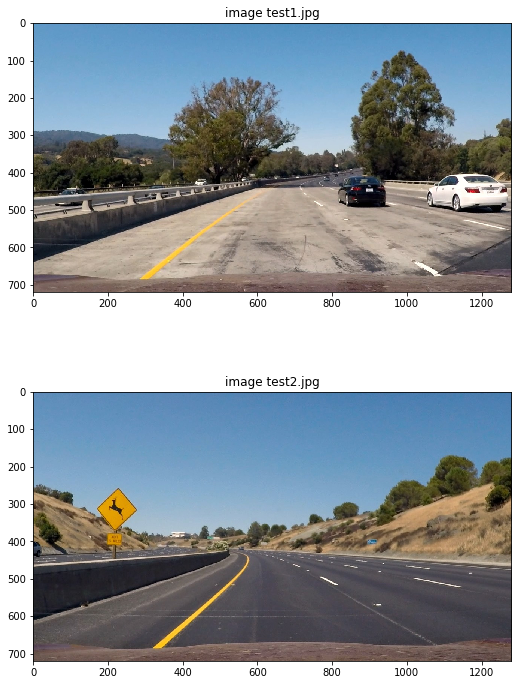

In [5]:
plot_images(raw_images[:2],None)

# Find the multi-scale sliding windows 

For each scale, given by a mask sike, find out the top/bottom and left/right limits.  
(I don't use the HOG sub-sampling window search) 

**Top limit** = 380

In [31]:
scales = [(40,40), (60,60), (90,90), (120,120), (170,170)]
overlaps = [0.25, 0.25, 0.5, 0.75, 0.75]
y_stops = [500, 550, 600, 650, None]
x_start_stops = [[400,850], [360,890], [320,930], [None, None], [None, None]]
colors = [(0,255,0), (255,0,0), (128,128,0), (0,128,128), (128,0,128)]

In [32]:
from project.utils import slide_window
help(slide_window)

Help on function slide_window in module project.utils:

slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5))



In [33]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):

    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return img

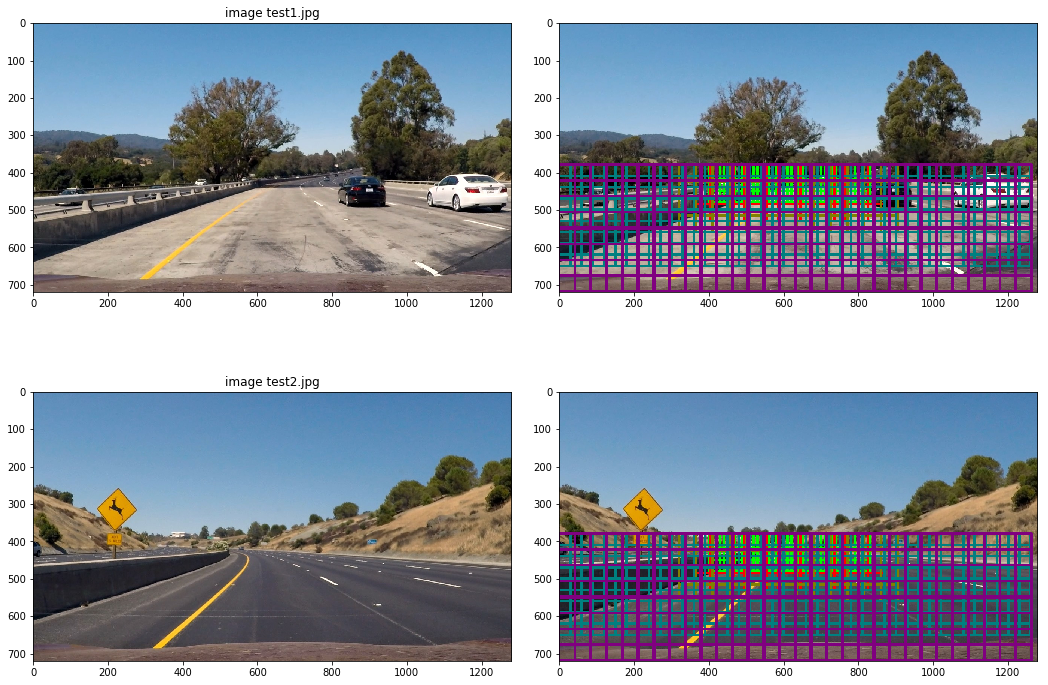

In [34]:
windowed_images = []
for image_name, image in raw_images:
    windowed_image = np.copy(image)
    for scale, overlap, color, y_stop, x_start_stop in zip(scales, overlaps, colors, y_stops, x_start_stops):
        
        windows = slide_window(windowed_image, x_start_stop=x_start_stop, y_start_stop=[380,y_stop],
                               xy_window=scale, xy_overlap=(overlap, overlap))
    
        windowed_image = draw_boxes(windowed_image, windows, color=color, thick=6) 
    
    windowed_images.append((image_name, np.copy(windowed_image)))

plot_images(raw_images[:2], windowed_images)

# Apply classifier on windows

In [35]:
color_space = settings_classifier["color_space"]
spatial_size = settings_classifier["spatial_size"]
hist_bins = settings_classifier["hist_bins"]
orient = settings_classifier["orient"]
pix_per_cell = settings_classifier["pix_per_cell"]
cell_per_block = settings_classifier["cell_per_block"]
hog_channel = settings_classifier["hog_channel"]
spatial_feat = settings_classifier["spatial_feat"]
hist_feat = settings_classifier["hist_feat"]
hog_feat = settings_classifier["hog_feat"]

In [36]:
#from project.utils import search_windows

In [37]:
from project.utils import color_hist, get_hog_features
import time

In [38]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel],
                                    orient, pix_per_cell, cell_per_block,
                                    vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [39]:
def search_windows(img, windows, clf, scaler, color_space='RGB',
                    spatial_size=(32, 32), hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).astype(np.float64).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

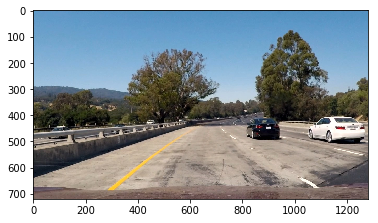

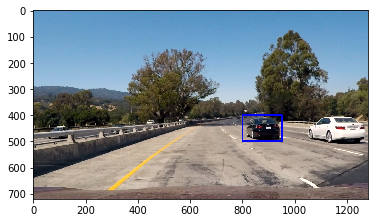

In [40]:
plt.imshow(raw_images[0][1])
plt.show()
copy = np.copy(raw_images[0][1])
copy = draw_boxes(copy, [[(800,500),(950,400)]])
plt.imshow(copy)

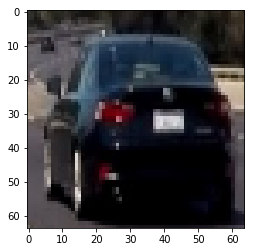

In [41]:
img_car = cv2.resize(img[400:500, 800:950], (64, 64))
plt.imshow(img_car)

In [42]:
#img_car = mpimg.imread('data/vehicles/KITTI_extracted/1.png')
features = single_img_features(img_car,color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)

In [43]:
test_features = scaler.transform(np.array(features).astype(np.float64).reshape(1, -1))
prediction = svc.predict(test_features)
print(prediction)

[ 1.]


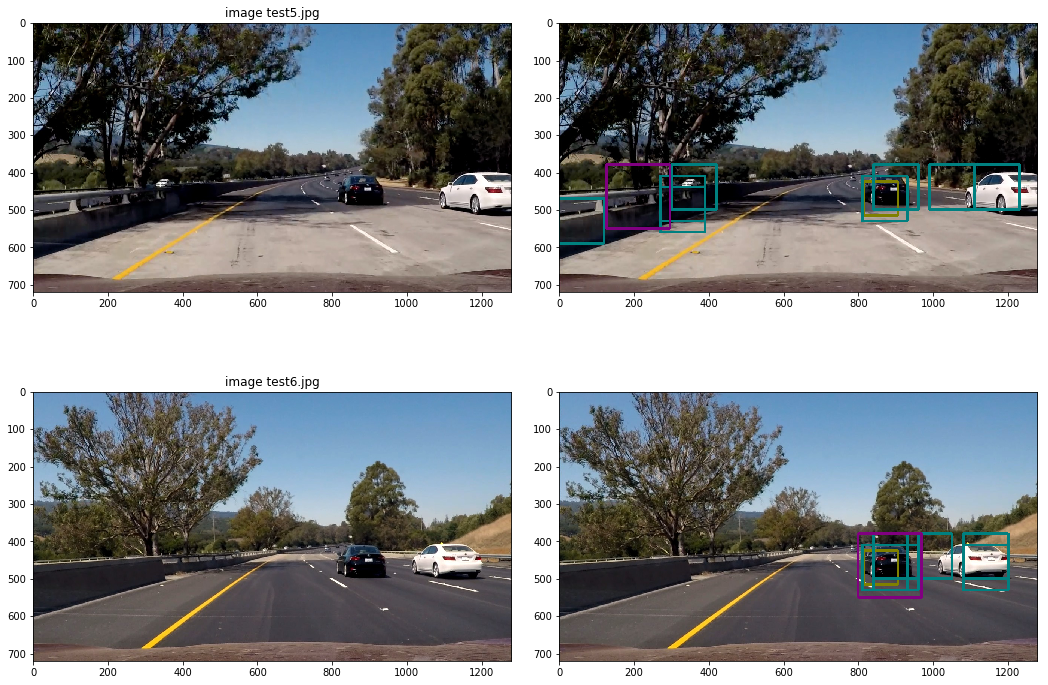

In [44]:
classified_images = []
for image_name, image in raw_images:
    windowed_image = np.copy(image)
    for scale, overlap, color, y_stop, x_start_stop in zip(scales, overlaps, colors, y_stops, x_start_stops):
        
        windows = slide_window(windowed_image, x_start_stop=x_start_stop, y_start_stop=[380,y_stop],
                               xy_window=scale, xy_overlap=(overlap, overlap))
        
        hot_windows = search_windows(image, windows, svc, scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)   
  
        windowed_image = draw_boxes(windowed_image, hot_windows, color=color, thick=6) 
    
    classified_images.append((image_name, windowed_image))

plot_images(raw_images[4:], classified_images[4:])

## Compute HeatMap

In [45]:
from scipy.ndimage.measurements import label

In [46]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

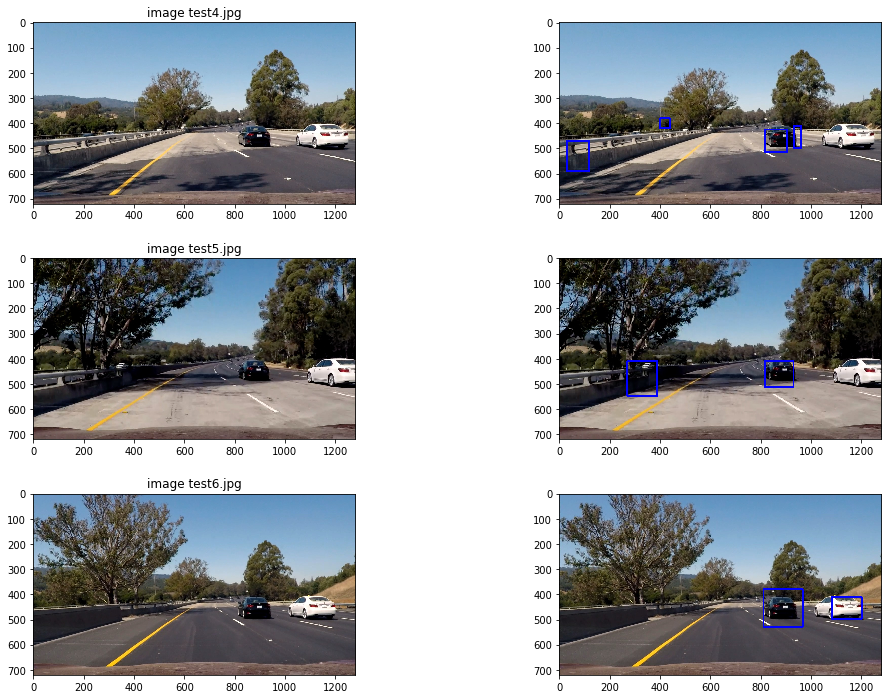

In [47]:
heatmap_images = []
labels_images = []
for image_name, image in raw_images:
    windowed_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    for scale, overlap, color, y_stop, x_start_stop in zip(scales, overlaps, colors, y_stops, x_start_stops):
        
        windows = slide_window(windowed_image, x_start_stop=x_start_stop, y_start_stop=[380,y_stop],
                               xy_window=scale, xy_overlap=(overlap, overlap))
        
        hot_windows = search_windows(image, windows, svc, scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)   
          
        heat = add_heat(heat,hot_windows)
        windowed_image = draw_boxes(windowed_image, hot_windows, color=color, thick=6) 
    
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    heatmap_images.append((image_name, heatmap))
    labels_images.append((image_name, draw_img))

# plot_images(raw_images[4:], heatmap_images[4:])
plot_images(raw_images[3:], labels_images[3:])